# Visualizing Chipotle's Data

This time we are going to pull data directly from the internet.
Special thanks to: https://github.com/justmarkham for sharing the dataset and materials.

### Step 1. Import the necessary libraries

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=8fe51fb51c502d4933096cc07cd9e480e9f637cc7c4b3a8bc1f89546c12d315b
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.functions import expr, col, mean, when, sum, count, desc, min, max
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [22]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
# set this so the graphs open internally
%matplotlib inline

### Step 2. Import the dataset from this [address](https://raw.githubusercontent.com/justmarkham/DAT8/master/data/chipotle.tsv).

In [4]:
!wget https://raw.githubusercontent.com/justmarkham/DAT8/master/data/chipotle.tsv

--2024-04-12 13:18:05--  https://raw.githubusercontent.com/justmarkham/DAT8/master/data/chipotle.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 364975 (356K) [text/plain]
Saving to: ‘chipotle.tsv’

chipotle.tsv        100%[===================>] 356.42K  --.-KB/s    in 0.03s   

2024-04-12 13:18:06 (9.98 MB/s) - ‘chipotle.tsv’ saved [364975/364975]



### Step 3. Assign it to a variable called chipo.

In [7]:
chipo = spark.read.csv('chipotle.tsv', sep = "\t", header=True, inferSchema=True)

### Step 4. See the first 10 entries

In [8]:
chipo.show(10)

+--------+--------+--------------------+--------------------+----------+
|order_id|quantity|           item_name|  choice_description|item_price|
+--------+--------+--------------------+--------------------+----------+
|       1|       1|Chips and Fresh T...|                NULL|    $2.39 |
|       1|       1|                Izze|        [Clementine]|    $3.39 |
|       1|       1|    Nantucket Nectar|             [Apple]|    $3.39 |
|       1|       1|Chips and Tomatil...|                NULL|    $2.39 |
|       2|       2|        Chicken Bowl|[Tomatillo-Red Ch...|   $16.98 |
|       3|       1|        Chicken Bowl|[Fresh Tomato Sal...|   $10.98 |
|       3|       1|       Side of Chips|                NULL|    $1.69 |
|       4|       1|       Steak Burrito|[Tomatillo Red Ch...|   $11.75 |
|       4|       1|    Steak Soft Tacos|[Tomatillo Green ...|    $9.25 |
|       5|       1|       Steak Burrito|[Fresh Tomato Sal...|    $9.25 |
+--------+--------+--------------------+-----------

### Step 5. Create a histogram of the top 5 items bought

In [27]:
! pip install sparkhistogram

In [29]:
top_items = chipo.groupBy('item_name').agg(F.sum('quantity').alias("sum_quantity")).orderBy("sum_quantity", ascending=False).limit(5)

In [30]:
top_items.show()

+-------------------+------------+
|          item_name|sum_quantity|
+-------------------+------------+
|       Chicken Bowl|         761|
|    Chicken Burrito|         591|
|Chips and Guacamole|         506|
|      Steak Burrito|         386|
|  Canned Soft Drink|         351|
+-------------------+------------+



In [32]:
top_items = top_items.collect()

In [33]:
top_items

[Row(item_name='Chicken Bowl', sum_quantity=761),
 Row(item_name='Chicken Burrito', sum_quantity=591),
 Row(item_name='Chips and Guacamole', sum_quantity=506),
 Row(item_name='Steak Burrito', sum_quantity=386),
 Row(item_name='Canned Soft Drink', sum_quantity=351)]

In [34]:
[item[1] for item in top_items]

[761, 591, 506, 386, 351]

<BarContainer object of 5 artists>

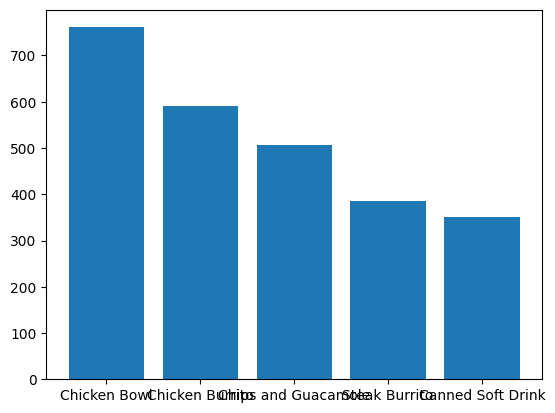

In [40]:

plt.bar([item[0] for item in top_items], [item[1] for item in top_items])


### Step 6. Create a scatterplot with the number of items orderered per order price
#### Hint: Price should be in the X-axis and Items ordered in the Y-axis

In [41]:
chipo = chipo.withColumn('item_price', expr("substring(item_price, 2, length(item_price))").cast(FloatType()))

In [46]:
grouped = chipo.groupBy("order_id").sum()
grouped.show(5)

+--------+-------------+-------------+------------------+
|order_id|sum(order_id)|sum(quantity)|   sum(item_price)|
+--------+-------------+-------------+------------------+
|     148|          592|            4|  30.9399995803833|
|     463|          926|            2|10.679999828338623|
|     471|         2355|            5|24.149999618530273|
|     496|         2480|            5|17.549999952316284|
|     833|         1666|            2|             12.75|
+--------+-------------+-------------+------------------+
only showing top 5 rows



In [52]:
x = grouped.select('sum(item_price)').rdd.flatMap(lambda x: x).collect()
y = grouped.select('sum(quantity)').rdd.flatMap(lambda x: x).collect()

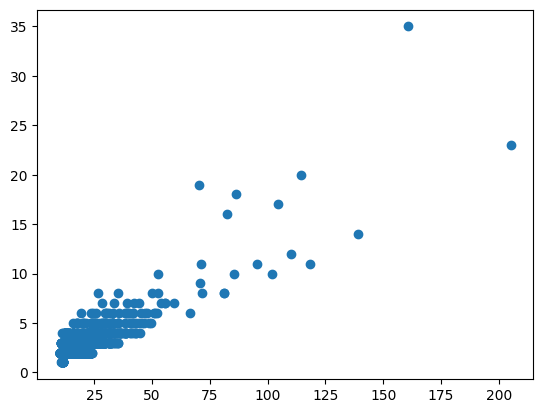

In [53]:
plt.scatter(x, y)

### Step 7. BONUS: Create a question and a graph to answer your own question.